# Team Classifier
From the observations, I have decided to create a model to classify a team's division rather than an individuals division.

In [248]:
import pandas as pd

In [249]:
df = pd.read_csv("Dataset/ultimate_college_championship.csv")
df.head()

,player,level,gender,division,team_name,Turns,Ds,Assists,Points,plus_minus,team_games,turns_per_game,ds_per_game,ast_per_game,pts_per_game,pls_mns_per_game
0,Jacques Nissen,Division 1,Men,Division 1 Men,Brown Brownian Motion,12,8,38,13,47,8,1.500000,1.000000,4.750000,1.625000,5.875
1,Cal Nightingale,Division 1,Men,Division 1 Men,Brown Brownian Motion,3,0,12,27,36,8,0.375000,0.000000,1.500000,3.375000,4.500
2,Faye Burdick,Division 1,Women,Division 1 Women,Colorado Quandary,6,12,16,13,35,7,0.857143,1.714286,2.285714,1.857143,5.000
3,Matthew Gregor,Division 3,Men,Division 3 Men,Franciscan Fatal,2,6,3,26,33,6,0.333333,1.000000,0.500000,4.333333,5.500
4,Frankie Saraniti,Division 3,Women,Division 3 Women,Carleton Eclipse,11,15,12,17,33,6,1.833333,2.500000,2.000000,2.833333,5.500


In [250]:
# Split by gender and get team ids
male_df = df[df['gender'] == 'Men'].drop(columns='team_games')
female_df = df[df['gender'] == 'Women'].drop(columns='team_games')
team_divs = df[['team_name', 'level', 'gender']].drop_duplicates().set_index(keys='team_name')
male_df = male_df.loc[:, "player":"plus_minus"]
female_df = female_df.loc[:, "player":"plus_minus"]

In [251]:
# Making Div 1 and Div 3 Bipolar
def make_bipolar(cell):
    if cell == 'Division 1':
        return 1
    return -1

In [252]:
# Processed data for modelling
def prepare_data(df, div):
    df_mean = df.groupby('team_name').mean(numeric_only=True)
    df_mean.columns = [col + ' mean' for col in df_mean.columns]
    df_stdev = df.groupby('team_name').std(numeric_only=True)
    df_stdev.columns = [col + ' stdev' for col in df_stdev.columns]
    new_df = df_mean.join(df_stdev)
    new_df = new_df.join(div['level'])
    new_df['level'] = new_df['level'].apply(make_bipolar)
    return new_df

In [253]:
# Make training model
male_teams_all = prepare_data(male_df, team_divs)
male_x_train = male_train.drop(columns='level')
male_y_train = male_train['level']

In [254]:
# Function that gets accuracy of results
def get_results(prediction, actual):
    data = {
        'Prediction': prediction,
        'Actual': actual
    }
    results = pd.DataFrame(data)
    num_correct = len(results[results['Prediction'] == results['Actual']])
    total = len(results)
    accuracy = round(num_correct/total * 100, 2)
    print(f"Accuracy: {accuracy}%")
    return results

In [255]:
from sklearn import tree

In [256]:
# Training Decision Tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(male_x_train, male_y_train)

# Test with 2025 Data

In [257]:
df_2025 = pd.read_csv("Dataset/2025 Database.csv")
df_2025.head()

,No.,Player,PronounsMere Info PronounsInterested in learning more about pronouns? Click here.,Position,Year,Height,Points,Assists,Ds,Turns,team_name,level,gender,division
0,1,Nima Lhamo,NaN,Cutter,College (JR),"6'0""",5.0,2.0,2.0,2.0,Massachusetts,Division 1,Men,Division 1Men
1,4,Ethan Lieman,NaN,NaN,College (FR),"8'2""",16.0,11.0,NaN,4.0,Massachusetts,Division 1,Men,Division 1Men
2,6,Roan Dunkerley,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,Massachusetts,Division 1,Men,Division 1Men
3,7,Ian Buchanan,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,Massachusetts,Division 1,Men,Division 1Men
4,8,Tomo Liou,NaN,Defense (Cutter),College (SO),"5'8""",3.0,NaN,NaN,2.0,Massachusetts,Division 1,Men,Division 1Men


In [258]:
# Removing columns and adding plus_minus
clean_2025 = df_2025[['Player', 'level', 'gender', 'division', 'team_name', 'Turns', 'Ds', 'Assists', 'Points']]
clean_2025 = clean_2025.fillna(0)
clean_2025['plus_minus'] = clean_2025['Points'] + clean_2025['Assists'] + clean_2025['Ds'] - clean_2025['Turns']
clean_2025.head()

,Player,level,gender,division,team_name,Turns,Ds,Assists,Points,plus_minus
0,Nima Lhamo,Division 1,Men,Division 1Men,Massachusetts,2.0,2.0,2.0,5.0,7.0
1,Ethan Lieman,Division 1,Men,Division 1Men,Massachusetts,4.0,0.0,11.0,16.0,23.0
2,Roan Dunkerley,Division 1,Men,Division 1Men,Massachusetts,4.0,0.0,0.0,4.0,0.0
3,Ian Buchanan,Division 1,Men,Division 1Men,Massachusetts,2.0,0.0,1.0,0.0,-1.0
4,Tomo Liou,Division 1,Men,Division 1Men,Massachusetts,2.0,0.0,0.0,3.0,1.0


In [259]:
# Catagorizing data
male_2025 = clean_2025[clean_2025['gender'] == 'Men']
women_2025 = clean_2025[clean_2025['gender'] == 'Women']
divs_2025 = clean_2025[['team_name', 'gender', 'level']].drop_duplicates().set_index(keys='team_name')

In [260]:
processed_2025 = prepare_data(male_2025, divs_2025)
test_2025_x = processed_2025.drop(columns='level')
test_2025_y = processed_2025['level']

In [261]:
predict = clf.predict(test_2025_x)
results = get_results(predict, test_2025_y)

Accuracy: 85.45%


[Text(0.5, 0.9, 'x[0] <= 3.639\ngini = 0.499\nsamples = 38\nvalue = [18, 20]'),
 Text(0.25, 0.7, 'x[3] <= 2.482\ngini = 0.33\nsamples = 24\nvalue = [5, 19]'),
 Text(0.375, 0.8, 'True  '),
 Text(0.125, 0.5, 'gini = 0.0\nsamples = 10\nvalue = [0, 10]'),
 Text(0.375, 0.5, 'x[4] <= 3.873\ngini = 0.459\nsamples = 14\nvalue = [5, 9]'),
 Text(0.25, 0.3, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.5, 0.3, 'x[6] <= 2.394\ngini = 0.298\nsamples = 11\nvalue = [2, 9]'),
 Text(0.375, 0.1, 'gini = 0.0\nsamples = 9\nvalue = [0, 9]'),
 Text(0.625, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.75, 0.7, 'x[5] <= 3.868\ngini = 0.133\nsamples = 14\nvalue = [13, 1]'),
 Text(0.625, 0.8, '  False'),
 Text(0.625, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.875, 0.5, 'gini = 0.0\nsamples = 13\nvalue = [13, 0]')]

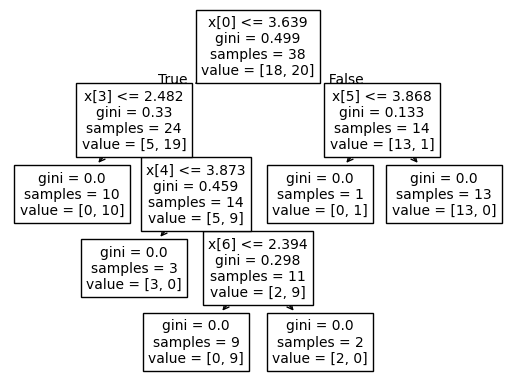

In [262]:
# Decision Tree Visualized
tree.plot_tree(clf)

# Training for Female Dataset

In [263]:
# Preparing datasets
female_teams_all = prepare_data(female_df, team_divs)
female_x_train = female_teams_all.drop(columns='level')
female_y_train = female_teams_all['level']

female_test_2025 = prepare_data(women_2025, divs_2025)
female_x_test = female_test_2025.drop(columns='level')
female_y_test = female_test_2025['level']

In [264]:
# New model
clf_female = tree.DecisionTreeClassifier()
clf_female = clf_female.fit(female_x_train, female_y_train)

In [265]:
# Testing model
predictions = clf_female.predict(female_x_test)
results = get_results(predictions, female_y_test)

Accuracy: 72.73%
